In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd

In [3]:
def process_dataframe(df):
    """
    Preprocess the 'hotel_name' column in the dataframe to standardize names by:
    - Converting to lowercase
    - Replacing accented characters with unaccented equivalents
    - Removing spaces, special characters, and digits
    - Removing common keywords like 'hotel'

    Parameters:
        df (pd.DataFrame): Dataframe with a 'hotel_name' column to preprocess.

    Returns:
        pd.DataFrame: Dataframe with the preprocessed 'hotel_name' column.
    """
    df['hotel_name_original'] = df['hotel_name']
    df['hotel_name'] = (
        df['hotel_name']
        .str.lower()
        .str.replace('ô', 'o')
        .str.replace('é', 'e')
        .str.replace('è', 'e')
        .str.replace('hotel', '')
        .str.replace('1', '')
        .str.replace('2', '')
        .str.replace('3', '')
        .str.replace('4', '')
        .str.replace('5', '')
        .str.replace('6', '')
        .str.replace('7', '')
        .str.replace('8', '')
        .str.replace('9', '')
        .str.replace('[^a-zA-Z0-9]', '', regex=True)  # Remove all special characters
    )

    # round dates to seconds to avoid floating point errors
    df['start_date'] = pd.to_datetime(df['start_date']).dt.round('s')
    df['end_date'] = pd.to_datetime(df['end_date']).dt.round('s')
    return df

In [4]:

# Combine Voyage Prive files
voyageprive_files = glob.glob("../../data/voyageprive_hotels_*.csv")
voyageprive_data = pd.concat([pd.read_csv(file) for file in voyageprive_files], ignore_index=True)

# Combine Verychic files
verychic_files = glob.glob("../../data/verychic_hotels_*.csv")
verychic_data = pd.concat([pd.read_csv(file) for file in verychic_files], ignore_index=True)

# Clean Voyage Prive data
voyageprive_data['price'] = voyageprive_data['price'].str.extract(r'(\d+\.?\d*)').astype(float)
voyageprive_data.rename(columns={'Country': 'country', 'hotel_name': 'hotel_name', 
                                  'start_date': 'start_date', 'end_date': 'end_date'}, inplace=True)

# Clean Verychic data
verychic_data.rename(columns={'Country': 'country', 'hotel_name': 'hotel_name', 
                               'start_date': 'start_date', 'end_date': 'end_date', 'Price': 'price'}, inplace=True)

# Convert dates to datetime
voyageprive_data['start_date'] = pd.to_datetime(voyageprive_data['start_date'])
voyageprive_data['end_date'] = pd.to_datetime(voyageprive_data['end_date'])
verychic_data['start_date'] = pd.to_datetime(verychic_data['start_date'])
verychic_data['end_date'] = pd.to_datetime(verychic_data['end_date'])


voyageprive_cleaned = process_dataframe(voyageprive_data)
verychic_cleaned = process_dataframe(verychic_data)


overlapping_deals = pd.merge(voyageprive_cleaned, verychic_cleaned, on='hotel_name', suffixes=('_vp', '_vc'))
overlapping_deals = overlapping_deals[
    (overlapping_deals['start_date_vp'] <= overlapping_deals['end_date_vc']) &
    (overlapping_deals['end_date_vp'] >= overlapping_deals['start_date_vc'])
]


# Count total and overlapping deals
total_deals = len(voyageprive_data) + len(verychic_data)
overlap_count = len(overlapping_deals)

In [5]:

# Calculate overlap durations
overlapping_deals['overlap_start'] = overlapping_deals[['start_date_vp', 'start_date_vc']].max(axis=1)
overlapping_deals['overlap_end'] = overlapping_deals[['end_date_vp', 'end_date_vc']].min(axis=1)
overlapping_deals['overlap_duration'] = (overlapping_deals['overlap_end'] - overlapping_deals['overlap_start']).dt.days

# Filter out invalid overlaps (negative durations, if any)
valid_overlaps = overlapping_deals[overlapping_deals['overlap_duration'] > 0]



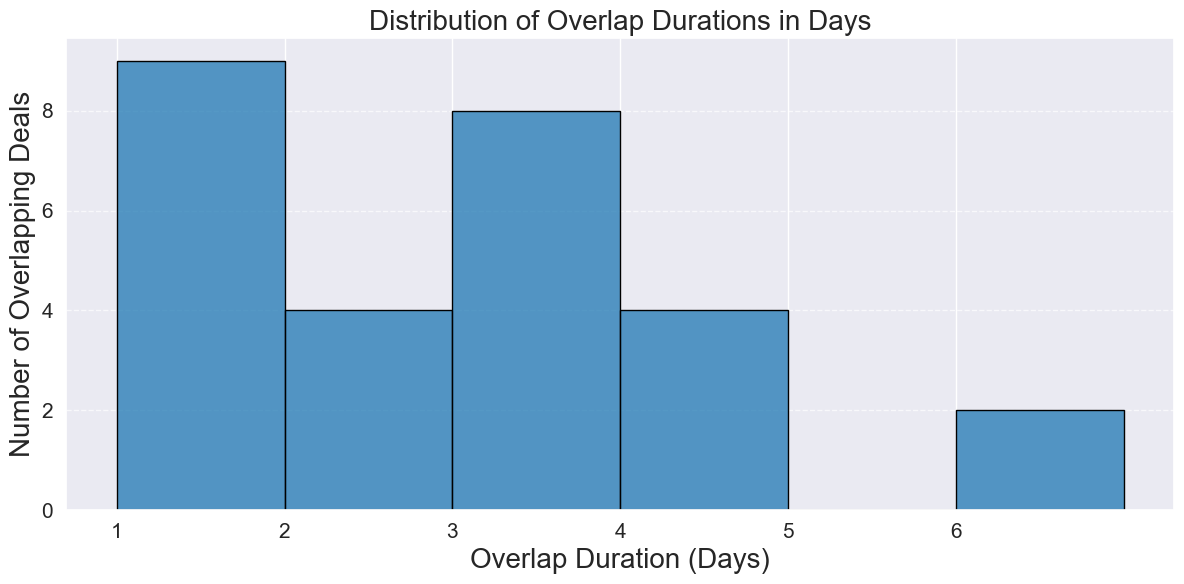

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style and color palette
sns.set_theme(style="darkgrid", palette="Paired")

# Plot histogram of overlap durations
plt.figure(figsize=(12, 6))
sns.histplot(
    valid_overlaps['overlap_duration'],
    bins=range(1, valid_overlaps['overlap_duration'].max() + 2),
    kde=False,
    color=sns.color_palette("Paired")[1],  # Choose a specific color from Paired
    edgecolor="black"
)

# Add labels and title
plt.title('Distribution of Overlap Durations in Days', fontsize=20)
plt.xlabel('Overlap Duration (Days)', fontsize=20)
plt.ylabel('Number of Overlapping Deals', fontsize=20)

# Customize ticks and gridlines
plt.xticks(range(1, valid_overlaps['overlap_duration'].max() + 1), fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tight layout for better spacing
plt.tight_layout()
plt.savefig('../../plots/overlap_duration_histogram.png')

# Show plot
plt.show()


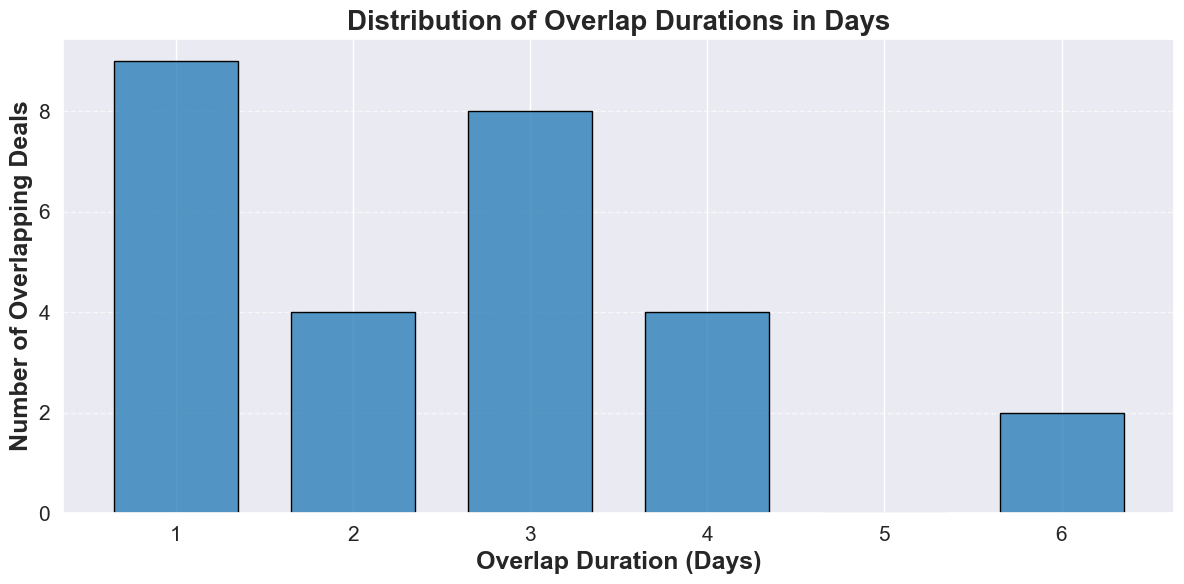

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set Seaborn style and color palette
sns.set_theme(style="darkgrid", palette="Paired")

# Calculate bins with a shift to align the bars with the x-ticks
bins = np.arange(1, valid_overlaps['overlap_duration'].max() + 2) - 0.5

# Plot histogram with shifted bins
plt.figure(figsize=(12, 6))
sns.histplot(
    valid_overlaps['overlap_duration'],
    bins=bins,
    kde=False,
    color=sns.color_palette("Paired")[1],  # Choose a specific color from Paired
    edgecolor="black",
    shrink=0.7  # Add white space between the bars
)

# Add labels and title
plt.title('Distribution of Overlap Durations in Days', fontsize=20, fontweight='bold')
plt.xlabel('Overlap Duration (Days)', fontsize=18, fontweight='bold')
plt.ylabel('Number of Overlapping Deals', fontsize=18, fontweight='bold')

# Customize ticks and gridlines
plt.xticks(range(1, valid_overlaps['overlap_duration'].max() + 1), fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tight layout for better spacing
plt.tight_layout()
plt.savefig('../../plots/overlap_duration_histogram.png')

# Show plot
plt.show()
